In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


Column information:

id - globally-unique time step identifier across an entire file

breath_id - globally-unique time step for breaths

R - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.

C - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.

time_step - the actual time stamp.

u_in - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.

u_out - the control input for the exploratory solenoid valve. Either 0 or 1.

pressure - the airway pressure measured in the respiratory circuit, measured in cmH2O.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


In [4]:
df.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


In [7]:
df.isnull().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64

Histogram of all columns, distribution of each feature

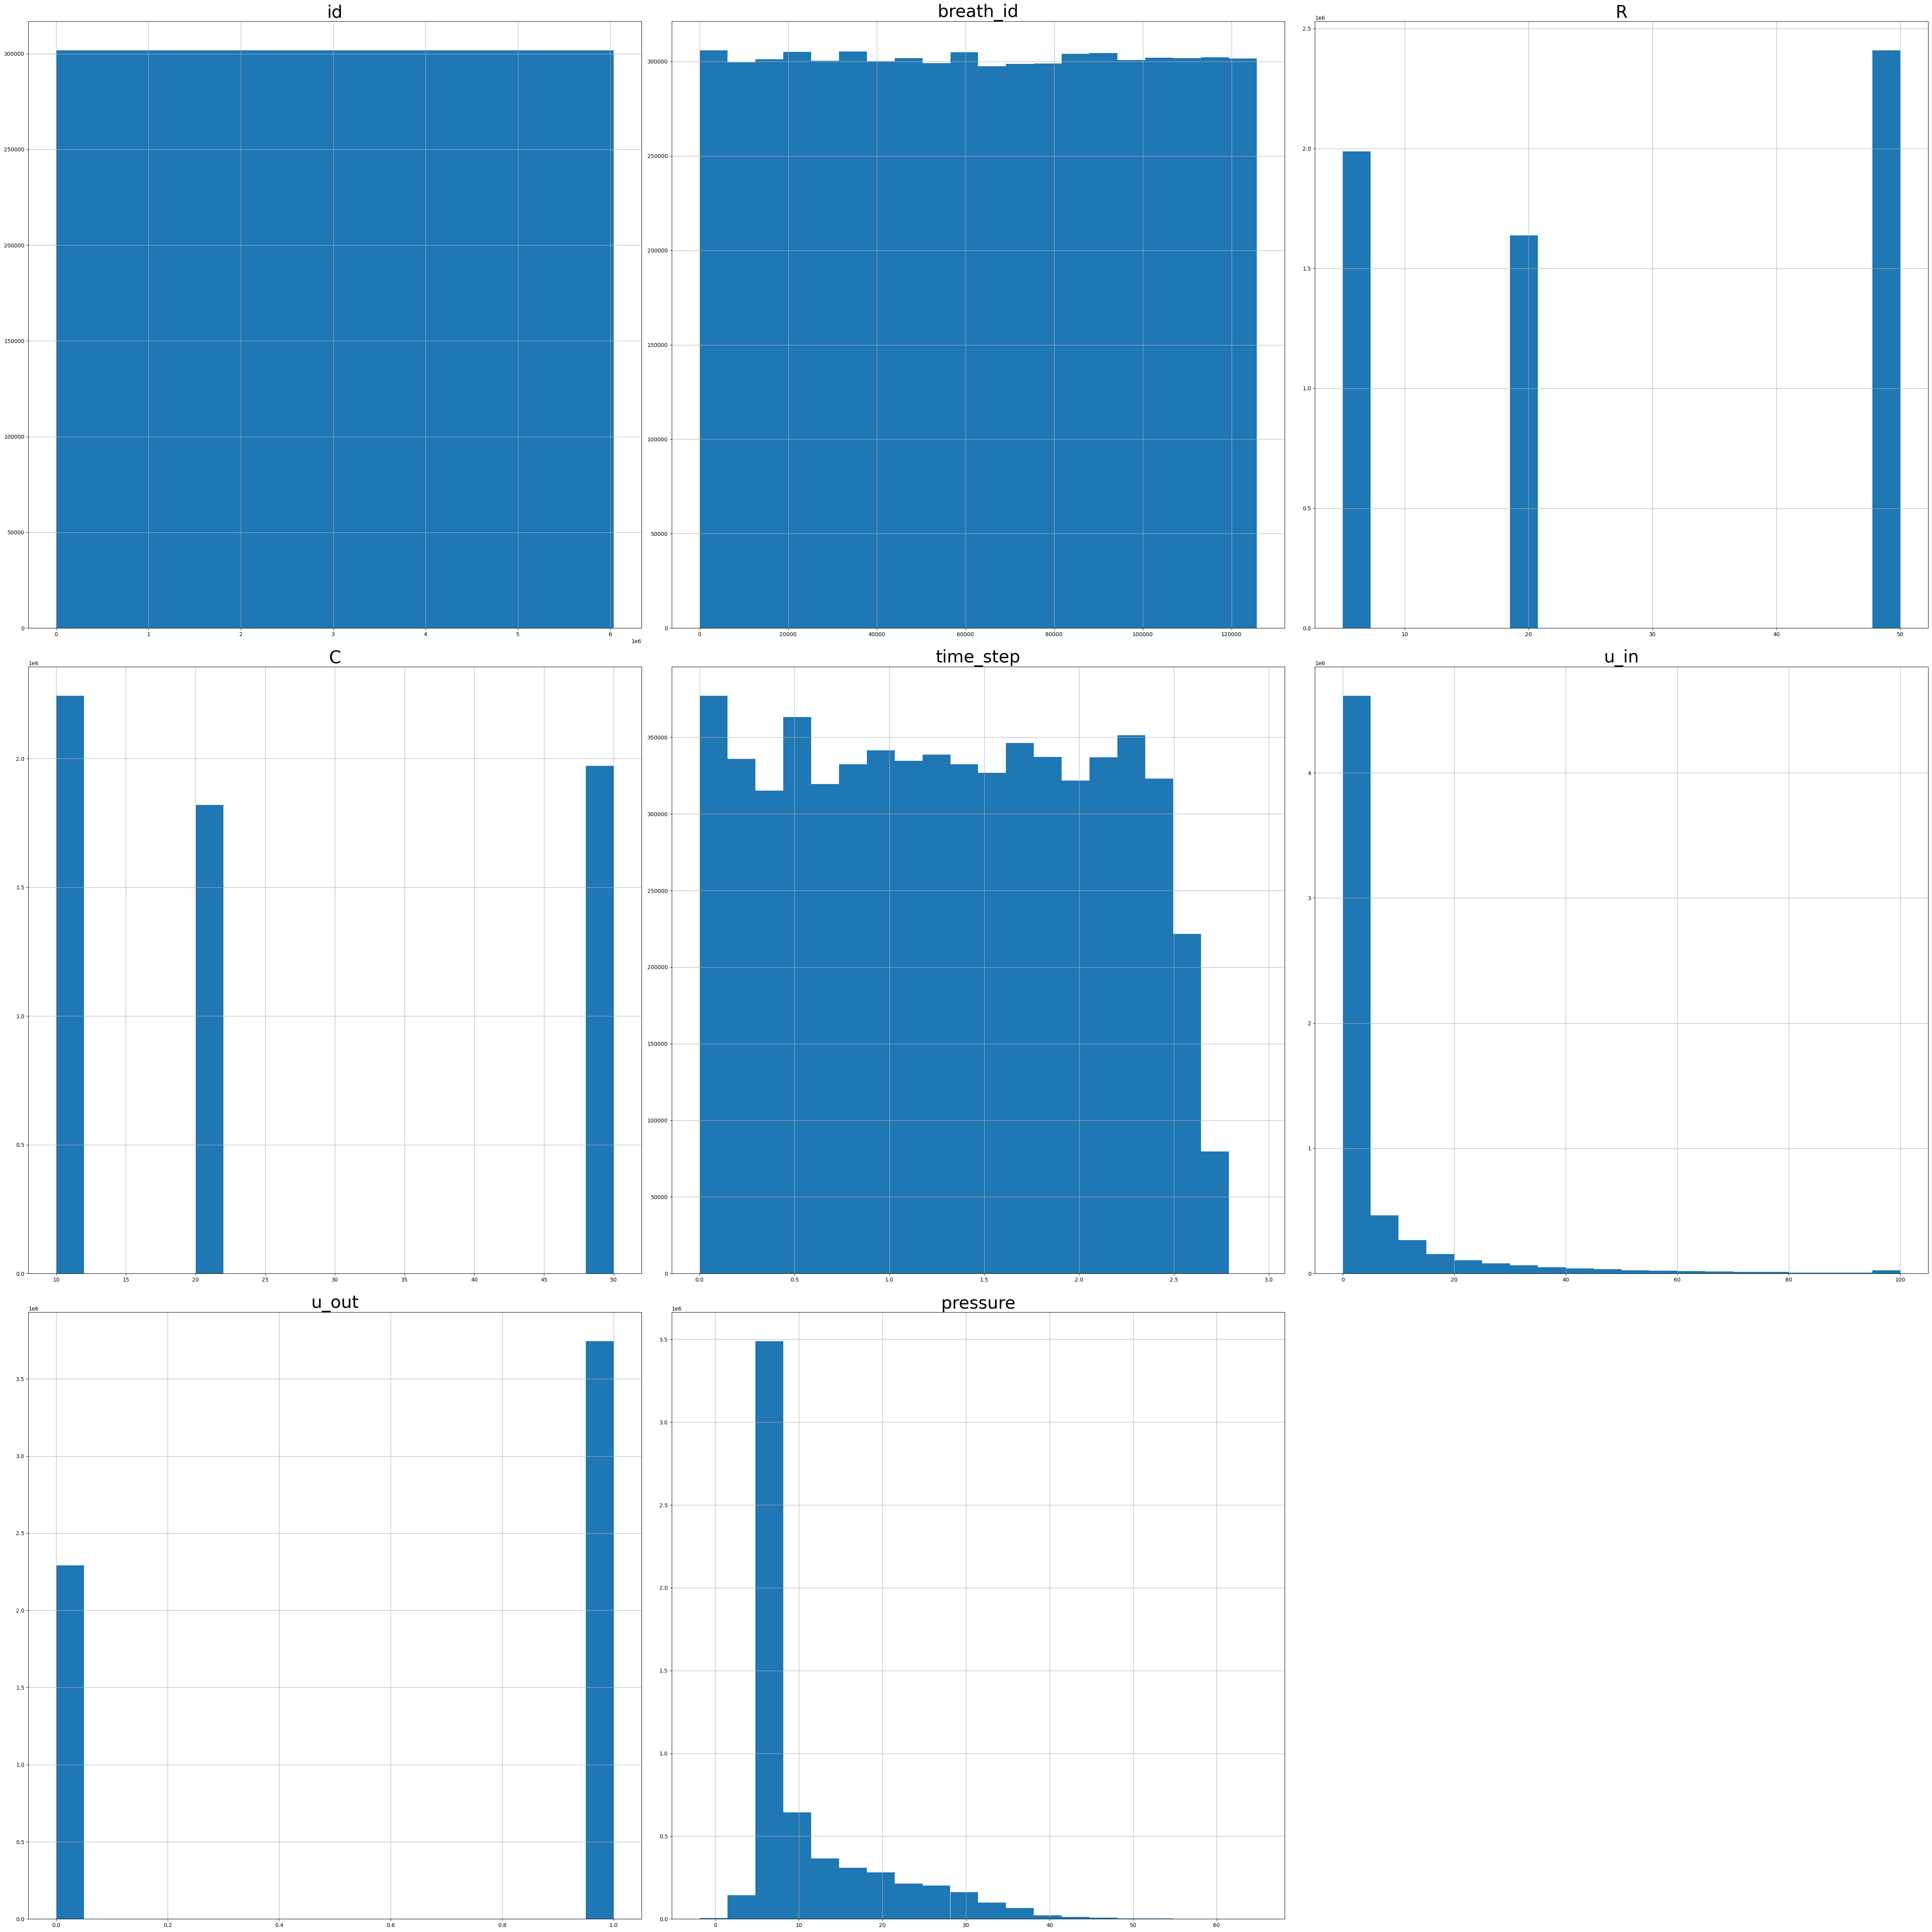

In [13]:
fig = df.hist(figsize=(50, 50), bins=20)
[x.title.set_size(32) for x in fig.ravel()]
plt.tight_layout()

<Axes: >

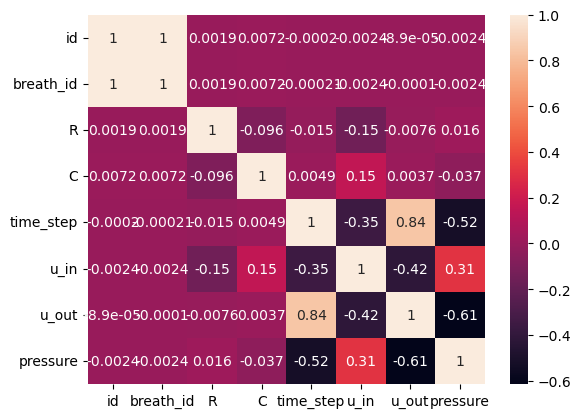

In [15]:
sns.heatmap(df.corr(), annot=True)

<Axes: xlabel='C', ylabel='count'>

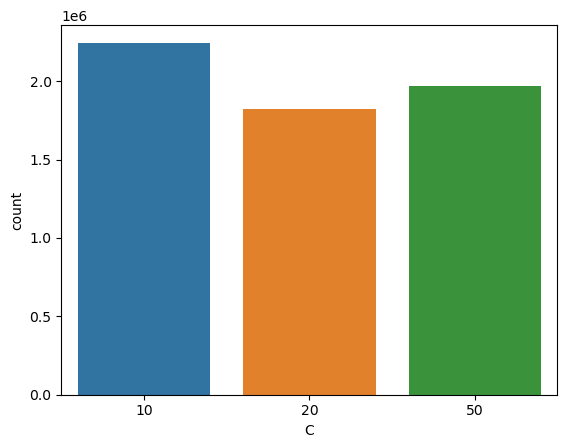

In [16]:
sns.countplot(df, x='C')

<Axes: xlabel='R', ylabel='count'>

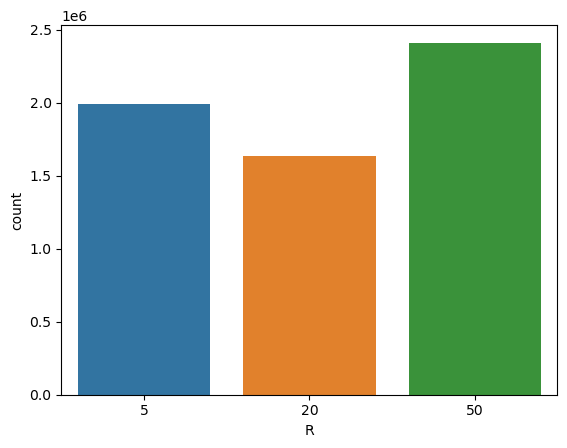

In [17]:
sns.countplot(df, x='R')

From the above plots, both features 'C' and 'R' are categorical

In [18]:
# investigate breathid
df['breath_id'].value_counts()

breath_id
1         80
83891     80
83924     80
83923     80
83922     80
          ..
41745     80
41743     80
41742     80
41741     80
125749    80
Name: count, Length: 75450, dtype: int64

In [29]:
def plot_breath(num_samples):
    breath_length = len(df[df['breath_id'] == 1])
    for i in range(num_samples):
        plt.plot(list(range(breath_length)), df[df['breath_id'] == i + 1]['pressure'])

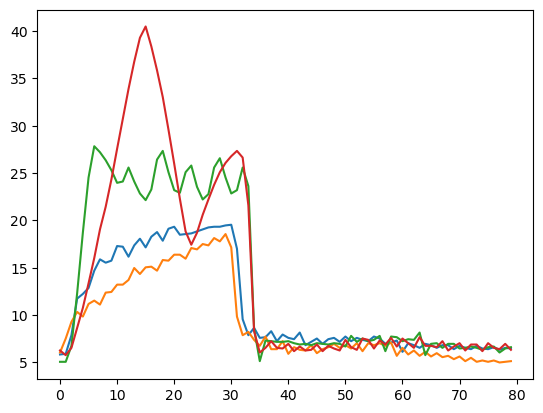

In [30]:
plot_breath(4)

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X = df.drop(columns=['pressure'])
y = df['pressure']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Decision Tree

In [44]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [35]:
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [36]:
dt_regressor.score(X_train, y_train)

1.0

In [37]:
dt_regressor.score(X_test, y_test)

0.6038932439756113

The simple decision tree obviously overfits the training data. Let's write a pipeline and find the best hyperparameters using grid search.

In [39]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['C', 'R'])
    ],
    remainder=StandardScaler()
)

dt_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor())
])

param_grid = {
    'regressor__max_depth': [None, 5, 10],
    'regressor__min_samples_split':[2, 5, 10],
    'regressor__min_samples_leaf':[1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

In [40]:
dt_grid = GridSearchCV(dt_pipe, param_grid=param_grid, scoring='neg_mean_squared_error', verbose=1)
dt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


c:\Users\hoo11155\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\hoo11155\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\hoo11155\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\hoo11155\AppData\Local\anaconda3\Lib\site-packa

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('cat',
                                                                         OneHotEncoder(),
                                                                         ['C',
                                                                          'R'])])),
                                       ('regressor', DecisionTreeRegressor())]),
             param_grid={'regressor__max_depth': [None, 5, 10],
                         'regressor__max_features': ['auto', 'sqrt', 'log2'],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error', verbose=1)

In [46]:
dt_grid.best_params_

{'regressor__max_depth': None,
 'regressor__max_features': 'sqrt',
 'regressor__min_samples_leaf': 4,
 'regressor__min_samples_split': 10}

In [45]:
y_pred = dt_grid.predict(X_train)
mae_train = mean_absolute_error(y_train, y_pred)
print(f"Mean absolute error training: {mae_train}")

Mean absolute error training: 1.314267196226582


In [49]:
y_pred_test = dt_grid.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f"Mean absolute error test: {mae_test}")

Mean absolute error test: 2.075609633912938
